In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/DiplomadoEPM_2019/master/Modulo3/init.py
from init import init; init(force_download=False)

In [1]:
try:
    %tensorflow_version 2.x
    print ("Using TF2 in Google Colab")
except:
    pass
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
%load_ext tensorboard

from sklearn.datasets import *
from local.lib import mlutils
tf.__version__

'2.1.0'

## TF is a symbolic computic + optimization library for machine learning problems

ML expressions involve:

- variables representing data as n-dimensional objects
- variables representing parameters as n-dimensional objects
- mostly matrix operations (multiplications, convolutions, etc.)
- some non linear operations (activation functions)


**Recall** that in `sympy` we **FIRST** define expressions (a computational graph) and **THEN** we evaluate them feed concrete values.

Tensorflow **INTEGRATES** both aspects so that building computational graphs **LOOKS LIKE** writing regular Pytohn code as must as possible.

- a `tf.Variable` represents a **symbolic** variable, that **contains a value**

In [2]:
x = tf.Variable(initial_value=[7], name="x", dtype=tf.float32)
y = tf.Variable(initial_value=[9], name="y", dtype=tf.float32)
f = x**2+y**3
f

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([778.], dtype=float32)>

for which TF can obtain gradients automatically

In [3]:
with tf.GradientTape(persistent=True) as t:
    f = x**2 + y**3
    
print (t.gradient(f, x), t.gradient(f, y))
    

tf.Tensor([14.], shape=(1,), dtype=float32) tf.Tensor([243.], shape=(1,), dtype=float32)


usually expressions are built within functions decorated with `@tf.function` for performance

In [4]:
@tf.function
def myf(x,y):
    return x**2 + y**3

In [5]:
with tf.GradientTape(persistent=True) as t:
    f = myf(x,y)
    
print (t.gradient(f, x), t.gradient(f, y))


tf.Tensor([14.], shape=(1,), dtype=float32) tf.Tensor([243.], shape=(1,), dtype=float32)


In [6]:
!rm -rf logs
mlutils.make_graph(myf, x, y, logdir="logs")


In [7]:
%tensorboard --logdir logs

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

## Implementing linear regresion in TF


(150, 1) (150,)


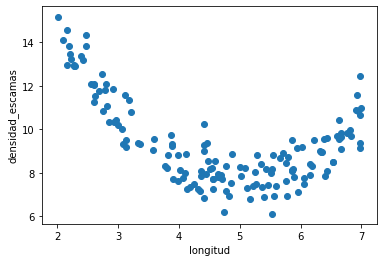

In [8]:
d = pd.read_csv("local/data/trilotropicos.csv")
y = d.densidad_escamas.values.astype(np.float32)
X = np.r_[[d.longitud.values]].T.astype(np.float32)

print(X.shape, y.shape)
plt.scatter(d.longitud, d.densidad_escamas)
plt.xlabel(d.columns[0])
plt.ylabel(d.columns[1]);

 ## Version 1: raw low level with gradient descent
 
- beware of typing. `tensorflow` is very sensitive to numeric data types (`tf.float32`, `tf.float64`, etc.) Default types in `numpy` and `tensorflow` might not always be the same

In [9]:
from progressbar import progressbar as pbar

epochs = 4000
learning_rate = 0.01

# symbolic variables
w = tf.Variable(np.random.normal(size=(X.shape[-1], 1), scale=.6), dtype=tf.float32)
b = tf.Variable(np.random.normal(size=(1,), scale=.6), dtype=tf.float32)

h = []

#optimization loop
for epoch in pbar(range(epochs)):
    with tf.GradientTape() as t:
        preds = tf.matmul(X,w)+b
        loss = tf.reduce_mean( (preds-y.reshape(-1,1))**2)
        
    gw, gb = t.gradient(loss, [w, b])
    
    w.assign_sub(learning_rate * gw)
    b.assign_sub(learning_rate * gb)
    
    h.append([gw.numpy()[0][0], gb.numpy()[0], w.numpy()[0][0], b.numpy()[0], loss.numpy()])
h = np.r_[h]
print (b.numpy(), w.numpy())

100% (4000 of 4000) |####################| Elapsed Time: 0:00:09 Time:  0:00:09


[12.677155] [[-0.71553564]]


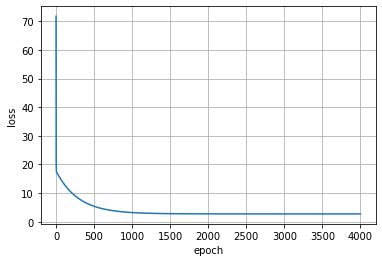

In [10]:
plt.plot(h[:,-1]); plt.xlabel("epoch"); plt.ylabel("loss"); plt.grid();

## Version 2: using `tf.function`

In [33]:
@tf.function
def get_gradient(X, y):
    with tf.GradientTape() as t:
        preds = tf.matmul(X,w)+b
        loss = tf.reduce_mean( (preds-y)**2)
        
    gw, gb = t.gradient(loss, [w, b])
    return gw, gb

#optimization loop
for epoch in pbar(range(epochs)):
        
    gw, gb = get_gradient(X, y.reshape(-1,1))
    
    w.assign_sub(learning_rate * gw)
    b.assign_sub(learning_rate * gb)
    
print (b.numpy(), w.numpy())

100% (4000 of 4000) |####################| Elapsed Time: 0:00:03 Time:  0:00:03


[12.686658] [[-0.7174028]]


## Version 3: packing up following Keras `class` API with custom loop

observe:

- the`build` method that is called by Keras whenever `input_shape` is known
- we use `add_weight` so that our model weights are known to the Keras model framework (`trainable_variables`, `get_weights`, etc.) 

see [here](https://www.tensorflow.org/guide/keras/custom_layers_and_models)

In [41]:
class LinearRegression(tf.keras.Model):
    
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True, dtype=tf.float32)
        
        self.b = self.add_weight(shape=(1,),
                                 initializer='random_normal',
                                 trainable=True, dtype=tf.float32)
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
    @tf.function
    def get_gradient(self, X, y):
        with tf.GradientTape() as t:
            loss = tf.reduce_mean( (self(X)-y)**2)

        gw, gb = t.gradient(loss, [self.w, self.b])
        return gw, gb

    def fit(self, X,y, epochs, learning_rate=0.01):
        #optimization loop
        y = y.reshape(-1,1)
        for epoch in pbar(range(epochs)):
            gw, gb = self.get_gradient(X,y)
            self.w.assign_sub(learning_rate * gw)
            self.b.assign_sub(learning_rate * gb)


In [48]:
lr = LinearRegression()

observe that we can use the object directly on data to get predictions

In [49]:
lr(X[:2])

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.12090292],
       [0.03192687]], dtype=float32)>

In [50]:
lr.trainable_variables

[<tf.Variable 'linear_regression_3/Variable:0' shape=(1, 1) dtype=float32, numpy=array([[0.05351591]], dtype=float32)>,
 <tf.Variable 'linear_regression_3/Variable:0' shape=(1,) dtype=float32, numpy=array([-0.08337774], dtype=float32)>]

In [51]:
lr.get_weights()

[array([[0.05351591]], dtype=float32), array([-0.08337774], dtype=float32)]

and fit the model

In [52]:
lr.fit(X, y, epochs=4000)

100% (4000 of 4000) |####################| Elapsed Time: 0:00:03 Time:  0:00:03


In [53]:
lr.b.numpy(), lr.w.numpy()

(array([12.677637], dtype=float32), array([[-0.7156305]], dtype=float32))

## Version 4: standard `keras` model


In [191]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
    
def get_model():
    model = Sequential()
    model.add(Dense(1, input_shape=(X.shape[-1],), activation="linear"))
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
                  loss="mse")
    return model

In [192]:
model = get_model()
model.fit(X,y, epochs=4000, batch_size=len(X), verbose=0)
model.weights

[<tf.Variable 'dense_27/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.7156559]], dtype=float32)>,
 <tf.Variable 'dense_27/bias:0' shape=(1,) dtype=float32, numpy=array([12.677767], dtype=float32)>]

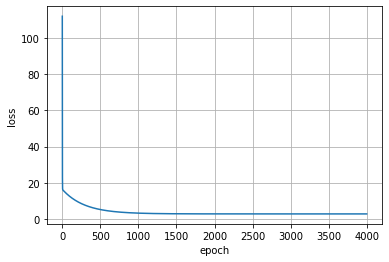

In [193]:
plt.plot(model.history.history["loss"]); plt.xlabel("epoch"); plt.ylabel("loss"); plt.grid();

## Version 5: Custom model with standard loop

In [194]:
class LinearRegression(tf.keras.Model):
    
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        
        self.b = self.add_weight(shape=(1,),
                                 initializer='random_normal',
                                 trainable=True)
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


In [195]:
lr = LinearRegression()
lr.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
           loss="mse")
lr.fit(X,y, epochs=4000, batch_size=len(X), verbose=0)

In [196]:
lr.b.numpy(), lr.w.numpy()[0]


(array([12.677712], dtype=float32), array([-0.71564525], dtype=float32))

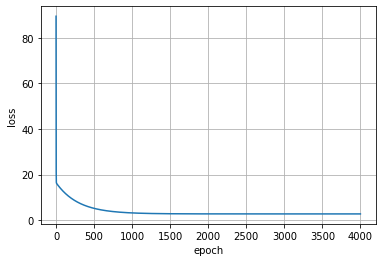

In [197]:
plt.plot(lr.history.history["loss"]); plt.xlabel("epoch"); plt.ylabel("loss"); plt.grid();

## Version 6: Custom loop with standard model

observe how we use the loss functions and `optimizer.apply_gradients`

In [198]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
    
def get_model():
    model = Sequential()
    model.add(Dense(1, input_shape=(X.shape[-1],), activation="linear"))
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
                  loss="mse")
    return model

our custom loop (**for any model** !!!)

In [213]:
model = get_model()

loss = model.loss_functions[0].fn
optimizer = model.optimizer

In [214]:
@tf.function
def train_step():
    with tf.GradientTape() as tape:
        loss_value = tf.reduce_mean(loss(model(X), y.reshape(-1,1)))
    grads = tape.gradient(loss_value, model.trainable_variables)

    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_value

h = []
for epoch in pbar(range(epochs)):
    loss_value = train_step()
    h.append(loss_value)

100% (4000 of 4000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


In [215]:
model.weights

[<tf.Variable 'dense_30/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.71566415]], dtype=float32)>,
 <tf.Variable 'dense_30/bias:0' shape=(1,) dtype=float32, numpy=array([12.677809], dtype=float32)>]

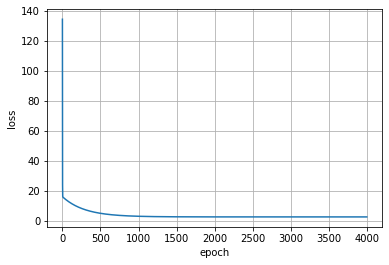

In [216]:
plt.plot(h); plt.xlabel("epoch"); plt.ylabel("loss"); plt.grid();